In [1]:
import numpy as np
import pandas as pd

import json
import gc
import string

from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import wordpunct_tokenize, word_tokenize, sent_tokenize
from gensim.test.utils import get_tmpfile

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

D:\programs\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Loading BokehJS ...

In [2]:
data = pd.read_csv('liberalnews.csv', index_col=0)
data.head()

,likes,reposts,text,public,date
0,1192,93,На 62-м году жизни скончался переводчик-синхро...,oldlentach,1566646026
1,1896,60,"А в Москве вот-вот начнётся митинг-концерт, по...",oldlentach,1566643750
2,714,20,Итоги первого дня выставки Disney D23 Expo: \n...,oldlentach,1566637773
3,3833,59,Новая модель космического корабля «Союз» с роб...,oldlentach,1566635524
4,3198,42,"Группа учёных из Чехии выяснила, что владельцы...",oldlentach,1566630014


In [3]:
data.index = np.arange(data.shape[0])

In [4]:
data.text = data.text.str.lower()
data.text = data.text.str.replace(
    'http\S+|www.\S+', '<URL>',
)

In [5]:
text = data.text.apply(word_tokenize)

In [6]:
def is_punct(word):
    punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»«—•'
    if len(word) == 1 and word in punct:
        return True
    else:
        return False

def remove_punctuation(sentence):
    return [word for word in sentence if not is_punct(word)]

text = text.apply(remove_punctuation)

In [7]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(list(text))]
del text
gc.collect()

0

In [27]:
model = Doc2Vec(
    vector_size=250, min_count=5, dm=1, window=5, workers=4,
)
model.build_vocab(documents)

In [28]:
model.train(
    documents,
    total_examples=model.corpus_count,
    epochs=40
)

In [43]:
N = 7262
s = data.text.iloc[N]
print(s)
print('.' * 8)
similar = model.docvecs.most_similar(N, topn=10)

for elem in similar:
    print(data.text.iloc[elem[0]])
    print(elem)
    print('.' * 8)

социологи из комитета гражданских инициатив подготовили доклад про общественные настроения россиян.

из него следует, что россияне перестали верить в сильную власть и готовы к переменам

<URL>
........
назван главный недостаток россиян

<URL>
(282956, 0.6496834754943848)
........
банкир михаил задорнов нашел плюсы в обеднении россиян
(36885, 0.6476845741271973)
........
канадцы оказались сильнее россиян в полуфинале кубка мира по хоккею. 

<URL>
(438287, 0.6382172107696533)
........
семья россиян утонула в собственном доме из-за сильного ливня

<URL>
(279721, 0.6329770088195801)
........
определен самый популярный у россиян музыкальный жанр

<URL>
(297611, 0.6298545598983765)
........
первый матч россиян на чемпионате мира по хоккею. онлайн!

<URL>
(128807, 0.6256369948387146)
........
будут россиян там искать

<URL>
(135428, 0.6237518787384033)
........
ес продлил санкции против россиян

<URL>
(275028, 0.6214865446090698)
........
третья медаль россиян на олимпиаде!
(109722, 0.6205883

In [42]:
model.save('liberals250.model')

D:\programs\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [46]:
pca = PCA(n_components=160)

X_pca = pca.fit_transform(vectors)
print(pca.explained_variance_ratio_.sum())

0.8406922268675971


In [ ]:
X_tsne = TSNE(n_components=2).fit_transform(X_pca)

In [41]:
def draw_vectors(x, y, radius=10, alpha=.25, color='blue',
                width=600, height=400, show=True, **kwargs):
    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({
        'x': x, 'y': y, 'color': color, **kwargs
    })
    
    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, 
                color='color', alpha=alpha, source=data_source)
    fig.add_tools(
        bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()])
    )
    
    if show:
        pl.show(fig)
    return fig

In [42]:
draw_vectors(X_tsne[:, 0], X_tsne[:, 1], token=data.text.values[indices])

Figure(id='1004', ...)

In [43]:
X_pca = PCA(n_components=2).fit_transform(vectors)
indices = np.random.choice(data.shape[0], 1000, replace=False)

In [44]:
draw_vectors(X_pca[indices, 0], X_pca[indices, 1], token=data.text.values[indices])

Figure(id='1111', ...)

D:\programs\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


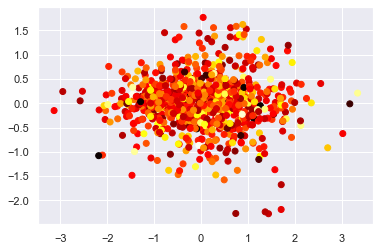

In [66]:
from sklearn.preprocessing import LabelEncoder

plt.scatter(
    X_pca[indices, 0], X_pca[indices, 1], 
    c=np.log(data.likes.values[indices]),
    cmap='hot'
)

In [59]:
data.public.value_counts(dropna=False)

lentaru             108039
meduzaproject        48343
novgaz               46006
svobodaradio         45882
echomsk              40943
NaN                  36280
satyrabezsortyra     28668
oldlentach           22715
mbkhmedia            18656
currenttime          18086
true_lentach         17200
tj                   14175
takiedela_ru         11675
eshkin_krot           2307
Name: public, dtype: int64

In [60]:
data[data.public.isna()]

,likes,reposts,text,public,date
98,NaN,NaN,NaN,NaN,NaN
129,NaN,NaN,NaN,NaN,NaN
148,NaN,NaN,NaN,NaN,NaN
176,NaN,NaN,NaN,NaN,NaN
227,NaN,NaN,NaN,NaN,NaN
249,NaN,NaN,NaN,NaN,NaN
263,NaN,NaN,NaN,NaN,NaN
269,NaN,NaN,NaN,NaN,NaN
274,NaN,NaN,NaN,NaN,NaN
283,NaN,NaN,NaN,NaN,NaN
